In [2]:
import pandas as pd
import time
import numpy as np
import re
import pickle
#import string, unicodedata
#from unidecode import unidecode

## Load Data

In [3]:
data = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'Sheet1')
komentar = data['komentar'].tolist()
label = data['label'].tolist()
#kode = data['kode'].tolist()

#data untuk confusion matrix
data = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'cm_data')
latih_cm = data['komentar'].tolist()
label_cm = data['label'].tolist()

## Seleksi Fitur

In [4]:
#proses membuat vocabularry
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#kosa_kata = set()

###seleksi fitur
#kk = CountVectorizer()
#kk.fit_transform(komentar)
#kosa_kata = kk.get_feature_names()
#print(len(kosa_kata))
#with open('model/feature.txt', 'w') as f:
    #for item in kosa_kata:
        #f.write("%s\n" % item)

## Proses Count Vectorizer

In [5]:
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#membuat TF-IDF
f = open("model/feature.txt")
kosa_kata = f.read().split()

countV = CountVectorizer(vocabulary = kosa_kata)
##Membuat Matrix TF-IDF
countV_matrix = countV.fit_transform(komentar)
X = countV_matrix.toarray()
Y = np.array(label)

#For confusion matrix
countV_matrix_ = countV.fit_transform(latih_cm) #For CM
print(countV_matrix.shape)
X_ = countV_matrix_.toarray()
Y_ = np.array(label_cm)

(3800, 13065)


## Proses Pemodelan

In [6]:
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score
from sklearn.naive_bayes import ComplementNB

### Input parameter

In [7]:
#parameter CNB
alpha = 0.38

#Parameter SVM
C = 1.8
gamma = 0.6

## K-Fold Cross Validation 
### jalanin aja dulu

In [6]:
#
K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
comNB = ComplementNB(alpha = alpha)

akurasi_svm = []
akurasi_cnb = []

for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM
    mCNB = comNB.fit(X_train, y_train)
            
    #proses prediksi
    P_SVM = mSVM.predict(X_test)
    P_CNB = mCNB.predict(X_test)
    
    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    akurasi_cnb.append(accuracy_score(y_test, P_CNB))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)
rerata_akurasi_cnb = sum(akurasi_cnb)/len(akurasi_cnb)

print("----------------------------------------")
print("Hasil K-Fold SVM")
print("   akurasi   :",round(rerata_akurasi_svm,2))

print("----------------------------------------")
print("Hasil K-Fold CNB")
print("   akurasi   :",round(rerata_akurasi_cnb,2))


----------------------------------------
Hasil K-Fold SVM
   akurasi   : 0.65
----------------------------------------
Hasil K-Fold CNB
   akurasi   : 0.93


# Confusion Matrix
## Proses Confusion Matrix untuk SVM

Confusion matrix, without normalization
[[493   7]
 [ 72 428]]
Normalized confusion matrix
[[0.99 0.01]
 [0.14 0.86]]


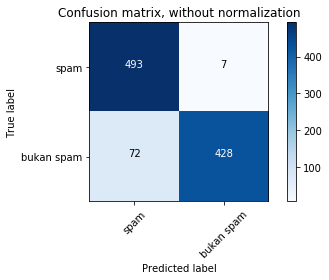

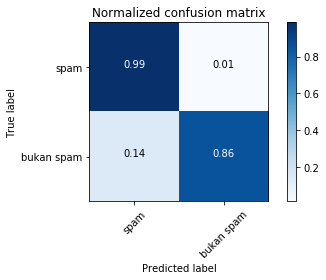

F-Measure (SVM)
----------------
akurasi   :  0.92
precision :  0.88
recall    :  0.99
f-Measure :  0.93


In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm#, datasets
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Split the data into a training set and a test set
"""data uji sebanyak 1000 komentar, 500 komentar berlabel spam dan 500 komentar berlabel buka sapam"""
index_train = [x for x in range(1000,3800)]
index__test = [x for x in range(1000)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test

class_names = ['spam', 'bukan spam']
classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
# Menghitung F Measure
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (SVM)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))

In [10]:
plt.show()

## Proses Confusion Matrix untuk CNB

Confusion matrix, without normalization
[[488  12]
 [ 51 449]]
Normalized confusion matrix
[[0.98 0.02]
 [0.1  0.9 ]]


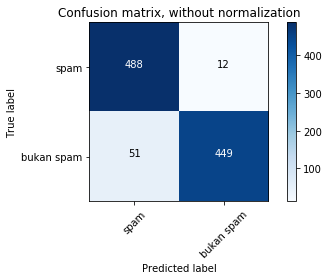

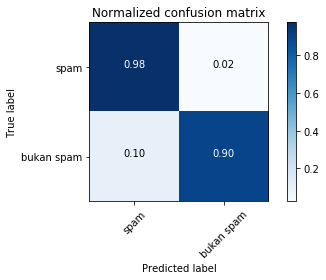

F-Measure (CNB)
----------------
akurasi   :  0.94
precision :  0.91
recall    :  0.98
f-Measure :  0.94


In [53]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# import some data to play with
class_names = ['spam', 'bukan spam']

# Split the data into a training set and a test set
index_train = [x for x in range(1000,3800)]
index__test = [x for x in range(1000)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]

cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test
y_train = cm_Y
y_test = cm_Y_test

classifier = ComplementNB(alpha = .18)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Menghitung F Measure

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],4)
fn= round(cm [0][1],4)
fp= round(cm [1][0],4)
tn= round(cm [1][1],4)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (CNB)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))

## Menyimpan model

In [34]:
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
comNB = ComplementNB(alpha = alpha)
#Melatih Model untuk data secara keseluruhan (X dan Y)
cSVM = cSVM.fit(X, Y) #SVN
comNB = comNB.fit(X, Y) #CNB

#save models
filename = 'model\cSVM.sav'
pickle.dump(cSVM, open(filename, 'wb'))
filename = 'model\comNB.sav'
pickle.dump(comNB, open(filename, 'wb'))

In [41]:
print(" "*90000)

##  komentar baru

In [ ]:
from modulku import preproses
#preproses.stemmer_stopWord("atau memakan nasi")

In [36]:
t_komentar = ["" for x in range (3800)]
#input_komentar = "Cek IG kami Kak, solusiii naiiikkk tinggiiii sampe 175cm, bahkan sampe umuur 33th masih bisa looh, Buruaaaaannn. '"
input_komentar = input("Komentar: ")
#komentar  = [cleaning2(input_komentar)]
komentar0 = preproses.preprocessing(input_komentar)
komentar_ = preproses.removePunc(komentar0)
komentar_ = preproses.stemmer_stopWord(komentar_)
t_komentar[-1]=komentar_
print("==============================================================================================================================")
print(komentar0)
print("==============================================================================================================================")

#t_clean_komentar_hapus = komentar_akhir
#komentar_siap = []
#komentar_siap.append(komentar)
#vocabulary = koso_kata
t_tfidf_matrix = tfidf.fit_transform(t_komentar)

data_X = t_tfidf_matrix.toarray()
#cek 
#x_cek = data_X[len(t_clean_komentar_hapus)-1:len(t_clean_komentar_hapus)]
x_cek = data_X[len(t_komentar)-1:len(t_komentar)]
#x_cek = data_X[-1]

# prediksi data asli
P_SVM = cSVM.predict(x_cek)
P_NB = comNB.predict(x_cek)

# print prediksi
print("Prediksi SVM (TF-IDF)           : ", P_SVM)
print("Prediksi C Naive Bayes (TF-IDF) : ", P_NB)
print(t_tfidf_matrix.shape)


Komentar: MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶÚ ĞÁK ĶÚŚÁMMMM ĹÁĞĨIIIII MÁĶÁŚĨĤH#@DR.KEYSA.FASHIONHERBAL 😍😍 ßÁŔÚ PÁĶĔ 2MĨŃĞĞÚ ÚĎÁĤ ĶĔĹĨÁŤÁŃ PĔŔÚßÁĤÁŃŃŶÁ ŴÁĴÁĤ ÁĶÚ ĴÚĞÁ ĴÁĎĨ ĶĔŃČĔŃĞ ĞÁ ĶĔĹĨÁŤÁŃ ĶĔŔĨPÚŤ ĹÁĞĨ hehe 💖💖💖
masker wajahnya oke banget kak sekarang wajahku gak kusammmm lagiiiiii makasihh @dr.keysa.fashionherbal baru pake 2minggu udah keliatan perubahannya wajah aku juga jadi kenceng ga keliatan keriput lagi hehe
Prediksi SVM (TF-IDF)           :  ['spam']
Prediksi C Naive Bayes (TF-IDF) :  ['spam']
(3800, 13065)


## Prediksi komentar baru lebih dari satu komentar

In [8]:
input_ = pd.read_excel("coba prediksi.xlsx") #memasukkan nama file excel berisi komentar baru (yang akan di cek)


input_list = input_['komentar'].tolist()
f_komentar = ["" for x in range (3800)]
list_komentar = input_list
join_komentar = preproses.preprocessing_implentasi(list_komentar) + f_komentar
print("*")
kokom = join_komentar[:3800]
f = open("model/feature.txt") 
voc = f.read().split()
t_tfidf = TfidfVectorizer(vocabulary = voc)
t_tfidf_matrix = tfidf.fit_transform(kokom)
cek_komentar = t_tfidf_matrix[:len(list_komentar)]
cek_komentar = cek_komentar.toarray()

#melakukan prediksi untuk komentar baru
P_SVM = cSVM.predict(cek_komentar)
P_NB = comNB.predict(cek_komentar)


dict = {'komentar':input_list, "prediksi svm":P_SVM, "prediksi CNB": P_NB}
df = pd.DataFrame(dict, columns=['komentar',"prediksi svm","prediksi CNB"])
df

*


NameError: name 'TfidfVectorizer' is not defined

In [98]:
df

,komentar,prediksi svm,prediksi CNB
0,Assalamualaikum wr.wb..!!!*PROMO BIG SALE 2018...,spam,spam
1,yg msh kangen momen2 asian games bisa klik lin...,spam,spam
2,ok klau begitu saya coba pake panelpediavip.co...,spam,spam
3,Ғollowwww IG @Marcella.beauty_specialist gaaa...,spam,spam
4,Moga lancar n sukses y kak via besuk sore diko...,bukan spam,bukan spam
5,Semingguuu yang laluuuu akuuu cobaaa cekkk ins...,spam,spam
6,THÀNKSSSSSS ÝÀ KÀK ÚDÀHHHHHHHH KÀSÌHHHHHHHH TÀ...,spam,spam
7,MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶ...,spam,spam
8,"ÀJÀÌBBBBBBBBB ρRÓDÚKNÝÀÀÀÀÀÀ KÀK , BÀNÝÀKKKKK ...",spam,spam
